# NDVI_mask_rainfall_percentiles

This code creates a boolean mask (true/false) from a GIS shapefile. The shapefile is read in, and locations inside the polygons are identified and labelled as "true", with areas outside of the polygons "false". This allows you to mask out data and analyse areas inside and outside the polygons separately. 

This mask is applied to NDVI data and the difference between areas inside and outside the polygons are analysed.

Created by Claire Krause,
November 2016,
Datacube version 1.1.12, Python v3

** Dependancies in this code: **
 - csv file with the lat/lon coordinates of the case study bounding box/es
 - csv file of the wet/dry years - produced from "BOM_wet_dry_times_loop_sites"
 - palaeovalleys 2012 shape file
 
** Accompanying code **

Accompanying code has been written for raijin to allow for multiple study sites to be processed at once. The code runs on a single CPU, which run on raijin in a non-interactive way. The outputs from this code are written into /g/data. These codes can be found https://github.com/CEKrause/Palaeovalleys_AGDC/tree/master/NDVI:

- NDVI_mask_rainfall_percentiles_loop.py (Python code similar to that below - just changed to run on raijin. Note that the file paths will need to be changed to match your own file pathways)
- Run_NDVI_percentiles(PBS submission script for raijin. Run by typing "qsub Run_NDVI_percentiles" into raijin from directory containing all the code dependency files)

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def return_good_pixels(nbar, pq):
    """
    This function uses pixel quality information to mask out and remove pixel quality artifacts from extracted data.
    """
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True}
    pqmask = masking.make_mask(pq.pixelquality,  **mask_components)
    return nbar.where(pqmask)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)
wetdry_times = pandas.read_csv('/g/data/p25/cek156/BOM_site_rainfall.csv', delimiter = ',')
print(wetdry_times)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

In [4]:
# Choose your site for this example
# Here we will select TiTree, located in row 10 (9 when you consider 0 indexing)
num = 40
Studysite = names.ix[num]
print(Studysite)

Name         Ord
minlat    -15.93
maxlat    -15.05
minlon     128.3
maxlon    129.29
Name: 40, dtype: object


In [5]:
#Because we have cut up the bounding boxes, there is no longer a relationship between the location of a site in 
#our rainfall data csv and bounding box csv. We will set up an index so that it's still correct
if 0 <= num <=3:
    bomnum = 0
    print('Using data from ' + wetdry_times.name[bomnum])
elif 4 <= num <=5:
    bomnum = 1
    print('Using data from ' + wetdry_times.name[bomnum])
elif 6 <= num <=23:
    bomnum = 2
    print('Using data from ' + wetdry_times.name[bomnum])
elif 24 <= num <=27:
    bomnum = 3
    print('Using data from ' + wetdry_times.name[bomnum])
elif 28 <= num <=39:
    bomnum = 4
    print('Using data from ' + wetdry_times.name[bomnum])
elif num ==40:
    bomnum = 5
    print('Using data from ' + wetdry_times.name[bomnum])
elif 41 <= num <=42:
    bomnum = 6
    print('Using data from ' + wetdry_times.name[bomnum])
elif num ==43:
    bomnum = 7
    print('Using data from ' + wetdry_times.name[bomnum])
elif 44 <= num <=45:
    bomnum = 8

Using data from Ord


Here is where you need to define the parameters of your analysis. There is an accompanying code that loops through these steps with all of the wet/dry times and case study sites. Here we are just demonstrating the functionality of the code, so we will choose just one wet year for our analysis. 

In [6]:
# Find the first wet year for our site
start_date = wetdry_times.wet[bomnum]
start_date = start_date.split("'")
start_date = start_date[3]
print(start_date)

# Split the string again so we can create the end date
Year, Month, Day = start_date.split('-')
# Now create the string for the end date - if it's December, make it 3, else just add 3 months
Monthnum = int(Month)
if Monthnum == 12:
    Monthnum = 3
    # And increment the year
    Year = int(Year)
    Year = Year + 1
    Year = str(Year)
else:
    Monthnum = Monthnum + 3
# Change it back to a string
Month = str(Monthnum)
# And zero pad it so that there are two numbers
Month = Month.zfill(2)

# Now construct the end date
end_date = Year + '-' + Month + '-' + Day
print(end_date)

1996-12-01
1997-03-01


In [7]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST

#Define temporal range
start_of_epoch = start_date
end_of_epoch =  end_date

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     #'swir2',
                     ]

#Define sensors of interest
sensor = ['ls8', 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch),
         'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]) }

query

{'lat': (-15.050000000000001, -15.93),
 'lon': (128.30000000000001, 129.28999999999999),
 'time': ('1996-12-01', '1997-03-01')}

These options will allow us to clean up the datacube data we are applying the mask to. Again, this is not important for the process of making the mask, but means that we have nice data to apply it to.

## Setting up our mask. 
This code reads in the shapefile and identifies and lists all of the polygons witin it. For this example, we are using the 2012 Palaeovalleys shape file (see English et al. 2012)

In [8]:
import geopandas as gp
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')
print (shp.head)

<bound method NDFrame.head of                                               geometry
0    POLYGON ((123.648953793 -30.56992565499991, 12...
1    (POLYGON ((117.1778376770001 -32.2709919609999...
2    POLYGON ((115.868565061 -29.73637336599995, 11...
3    POLYGON ((115.948200584 -27.86854227199996, 11...
4    POLYGON ((127.387641593 -28.59592641999996, 12...
5    POLYGON ((128.0569520910001 -28.54635345199995...
6    POLYGON ((128.698006552 -26.21770164599991, 12...
7    POLYGON ((126.722619924 -22.32913755999994, 12...
8    POLYGON ((128.3006654730001 -18.96357787199992...
9    POLYGON ((115.3584853260001 -27.20097888599992...
10   POLYGON ((126.9556900690001 -26.30121716599996...
11   POLYGON ((115.8733712540001 -25.14138591099993...
12   POLYGON ((125.9475394960001 -28.62771558199995...
13   POLYGON ((124.9745967660001 -29.53551659999994...
14   POLYGON ((120.9398331570001 -19.64230130599992...
15   POLYGON ((128.361469574 -22.02882464999993, 12...
16   POLYGON ((123.9446491120001 -3

This section filters our polygons, to find only those that are within the bounding box we specified above. It then combines all the relevant polygons into a single polygon that we can use to create our mask.

In [9]:
# Create a bounding box from the locations specified above
box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

## Grab some data from the datacube using the query we built above. 
We are then going to clean up the data to remove poor quality pixels, and create a mean so we only have one time step to play with.

<xarray.Dataset>
Dimensions:  (x: 4376, y: 3974)
Coordinates:
  * y        (y) float64 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 ...
  * x        (x) float64 -4.012e+05 -4.012e+05 -4.012e+05 -4.011e+05 ...
Data variables:
    red      (y, x) float64 824.0 824.0 853.0 867.5 882.0 896.5 896.5 867.5 ...
    nir      (y, x) float64 2.176e+03 2.176e+03 1.982e+03 1.924e+03 ...
    ndvi     (y, x) float64 0.4511 0.4511 0.3987 0.3788 0.3714 0.3771 0.3893 ...


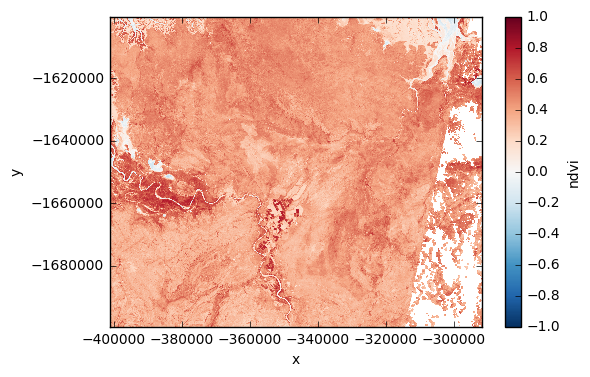

In [10]:
# Pull in some data from the datacube to apply our mask to
dc = datacube.Datacube(app='poly-drill-recipe')
# Grab data from all three sensors (ls5, ls7 and ls8). We will loop through the three sensors, then calculate an average.
sensor_all = len(sensor)
sens = 1
for sensor_iterable in range (0,sensor_all):
#Retrieve the data and pixel quality (PQ) data for sensor n
     nbar = dc.load(product = sensor[sensor_iterable] +'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
     if nbar :    
        pq = dc.load(product = sensor[sensor_iterable] +'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        crs = nbar.crs.wkt
        affine = nbar.affine
        geobox = nbar.geobox
        # Filter the data to remove bad pixels
        nbar = return_good_pixels(nbar, pq)
        nbar['ndvi'] = (nbar['nir'] - nbar['red']) / (nbar['nir'] + nbar['red'])
        if sens == 1:
            allsens = nbar
            sens = sens + 1
        elif sens == 2:
            allsens = xr.concat([allsens, nbar], dim = 'new_dim')
            sens = sens + 1
        else:
            nbar = xr.concat([nbar], dim = 'new_dim')
            allsens = xr.concat([allsens, nbar], dim = 'new_dim')
            sens = sens + 1                 
if sens >= 3:
    datamean = allsens.mean(dim = 'new_dim') 
    datamean = datamean.mean(dim = 'time')
else:
    datamean = allsens.mean(dim = 'time')

print(datamean)
fig = datamean.ndvi.plot()
fig.set_clim(-1, 1)

## This is where we actually create our mask, and apply it to the data we extracted from the datacube.

In [11]:
# Create the mask based on our shapefile
mask = geometry_mask(warp_geometry(shp_union, shp.crs, crs), geobox, invert=True)
# Get data only where the mask is 'true'
data_masked = datamean.where(mask)
print(data_masked)

<xarray.Dataset>
Dimensions:  (x: 4376, y: 3974)
Coordinates:
  * y        (y) float64 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 ...
  * x        (x) float64 -4.012e+05 -4.012e+05 -4.012e+05 -4.011e+05 ...
Data variables:
    red      (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    nir      (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    ndvi     (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...


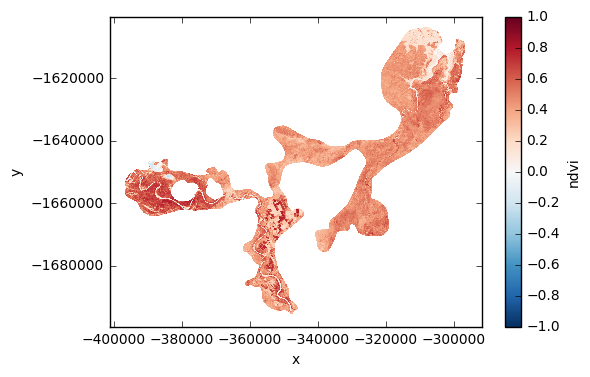

In [12]:
# Plot the masked dataset
fig = data_masked.ndvi.plot(cmap = 'RdBu_r')
# set the colorbar range to +-1
fig.set_clim(-1, 1)

## We can also get the inverse mask i.e. areas that are outside of our polygon, but still within the bounding box.

In [13]:
# Get data only where the mask is 'false'
data_maskedF = datamean.where(~ mask)
print(data_maskedF)

<xarray.Dataset>
Dimensions:  (x: 4376, y: 3974)
Coordinates:
  * y        (y) float64 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 -1.6e+06 ...
  * x        (x) float64 -4.012e+05 -4.012e+05 -4.012e+05 -4.011e+05 ...
Data variables:
    red      (y, x) float64 824.0 824.0 853.0 867.5 882.0 896.5 896.5 867.5 ...
    nir      (y, x) float64 2.176e+03 2.176e+03 1.982e+03 1.924e+03 ...
    ndvi     (y, x) float64 0.4511 0.4511 0.3987 0.3788 0.3714 0.3771 0.3893 ...


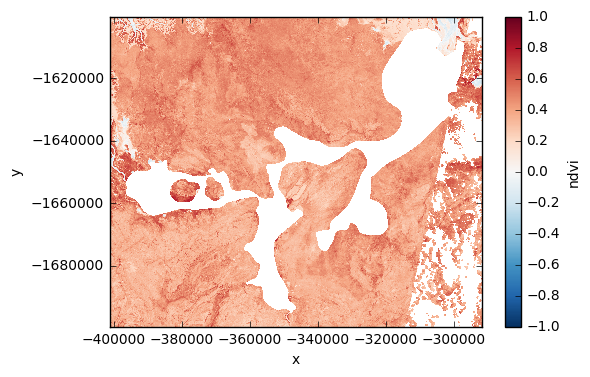

In [14]:
# Plot the opposite masked dataset
fig = data_maskedF.ndvi.plot()
# set the colorbar range to +-1
fig.set_clim(-1, 1)

## See if the data inside the polygon is different to that outside

(array([  7.37000000e+03,   6.34900000e+03,   6.95000000e+03,
          7.18900000e+03,   7.57600000e+03,   8.38500000e+03,
          9.74900000e+03,   1.06900000e+04,   1.00950000e+04,
          1.04880000e+04,   9.00900000e+03,   8.74000000e+03,
          8.80700000e+03,   1.00890000e+04,   1.71930000e+04,
          2.95160000e+04,   3.71020000e+04,   3.89760000e+04,
          4.05000000e+04,   3.82050000e+04,   3.51500000e+04,
          3.45570000e+04,   3.77580000e+04,   4.54350000e+04,
          5.83880000e+04,   7.95180000e+04,   1.07234000e+05,
          1.44809000e+05,   1.94202000e+05,   2.63064000e+05,
          3.31714000e+05,   3.91518000e+05,   4.32104000e+05,
          4.60172000e+05,   4.71801000e+05,   4.91450000e+05,
          5.15423000e+05,   5.38410000e+05,   5.73055000e+05,
          5.99656000e+05,   6.20992000e+05,   6.27952000e+05,
          6.25474000e+05,   6.06750000e+05,   5.82232000e+05,
          5.25403000e+05,   5.13677000e+05,   4.41060000e+05,
        

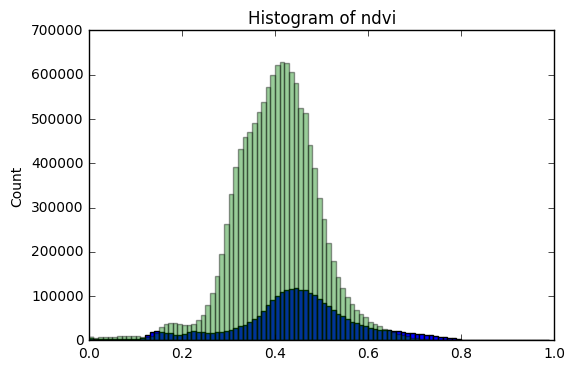

In [15]:
bin_values = np.arange(start = 0, stop = 1, step = 0.01)
data_masked.ndvi.plot.hist(bins = bin_values)
data_maskedF.ndvi.plot.hist(alpha = 0.4, bins = bin_values)

In [16]:
# Create a new numpy array with just the ndvi values
data_masked2 = np.array(data_masked.ndvi)
data_maskedF2 = np.array(data_maskedF.ndvi)
print(data_masked2)
print(data_maskedF2)

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]
[[ 0.45110757  0.45110757  0.39874447 ...,         nan         nan
          nan]
 [ 0.54662334  0.47153348  0.42871626 ...,         nan         nan
          nan]
 [ 0.55421337  0.48109733  0.43317707 ...,         nan         nan
          nan]
 ..., 
 [ 0.36608058  0.37224691  0.38394207 ...,  0.54501835  0.52441031
   0.5229992 ]
 [ 0.36205494  0.36019123  0.37183485 ...,  0.52995392  0.52995392
   0.48639113]
 [ 0.34780558  0.36235694  0.36807877 ...,  0.49312169  0.48728927
   0.44902284]]


In [17]:
data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
print(data_masked_nonan)
print(data_maskedF_nonan)

[ 0.29396577  0.3005608   0.30089203 ...,  0.35725524  0.36454826
  0.31745353]
[ 0.45110757  0.45110757  0.39874447 ...,  0.49312169  0.48728927
  0.44902284]


In [18]:
masked_both = [data_masked_nonan,data_maskedF_nonan]
print(masked_both)
# How many data points are in each of my NDVI lists?
size = ([len(i) for i in masked_both])
print(size)

[array([ 0.29396577,  0.3005608 ,  0.30089203, ...,  0.35725524,
        0.36454826,  0.31745353]), array([ 0.45110757,  0.45110757,  0.39874447, ...,  0.49312169,
        0.48728927,  0.44902284])]
[2836721, 13048024]


([<matplotlib.axis.XTick at 0x7f0d1c0e0d30>,
 <a list of 2 Text xticklabel objects>)

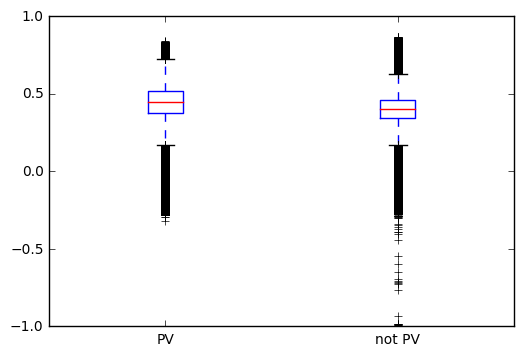

In [19]:
bp = plt.boxplot(masked_both)
plt.xticks([1,2],['PV', 'not PV'])

## Are our two datasets statistically different?

In [20]:
# Test with an unpaired t-test. Equal var is false because our populations are different sizes
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_ttest = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
print(stats_ttest)

Ttest_indResult(statistic=526.09758553759377, pvalue=0.0)


In [21]:
# Test with a Kolmogorov-Smirnov test 
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_KS = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)
print(stats_KS)

Ks_2sampResult(statistic=0.20405643672552165, pvalue=0.0)
